# Forest Fire visualization project

### Import packages

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.palettes import Category20c, Spectral6
from bokeh.transform import cumsum, linear_cmap
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Grid, LinearInterpolator

from IPython import __version__ as ipython_version
from pandas import __version__ as pandas_version
from bokeh import __version__ as bokeh_version

output_notebook()

Loading BokehJS ...

### Activate dataset

In [3]:
forest = pd.read_csv('../data/raw/forestfires.csv')
forest.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
forest.shape # 517 rows and 13 variables

(517, 13)

In [5]:
forest.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [6]:
forest.isnull().sum() # No missing values

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

### Sort the dataframe in order of month

In [7]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

In [8]:
forest['month'] = pd.Categorical(forest['month'], categories=months, ordered=True)
forest = forest.reset_index(forest.sort_values(by='month', inplace=True), drop=True)
forest.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,2,4,jan,sat,82.1,3.7,9.3,2.9,5.3,78,3.1,0.0,0.00
1,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00
2,3,4,feb,sat,83.9,8.0,30.2,2.6,12.7,48,1.8,0.0,0.00
3,2,2,feb,fri,86.6,13.2,43.0,5.3,12.3,51,0.9,0.0,0.00
4,7,4,feb,sun,83.9,8.7,32.1,2.1,8.8,68,2.2,0.0,13.05


### Density plot of the data

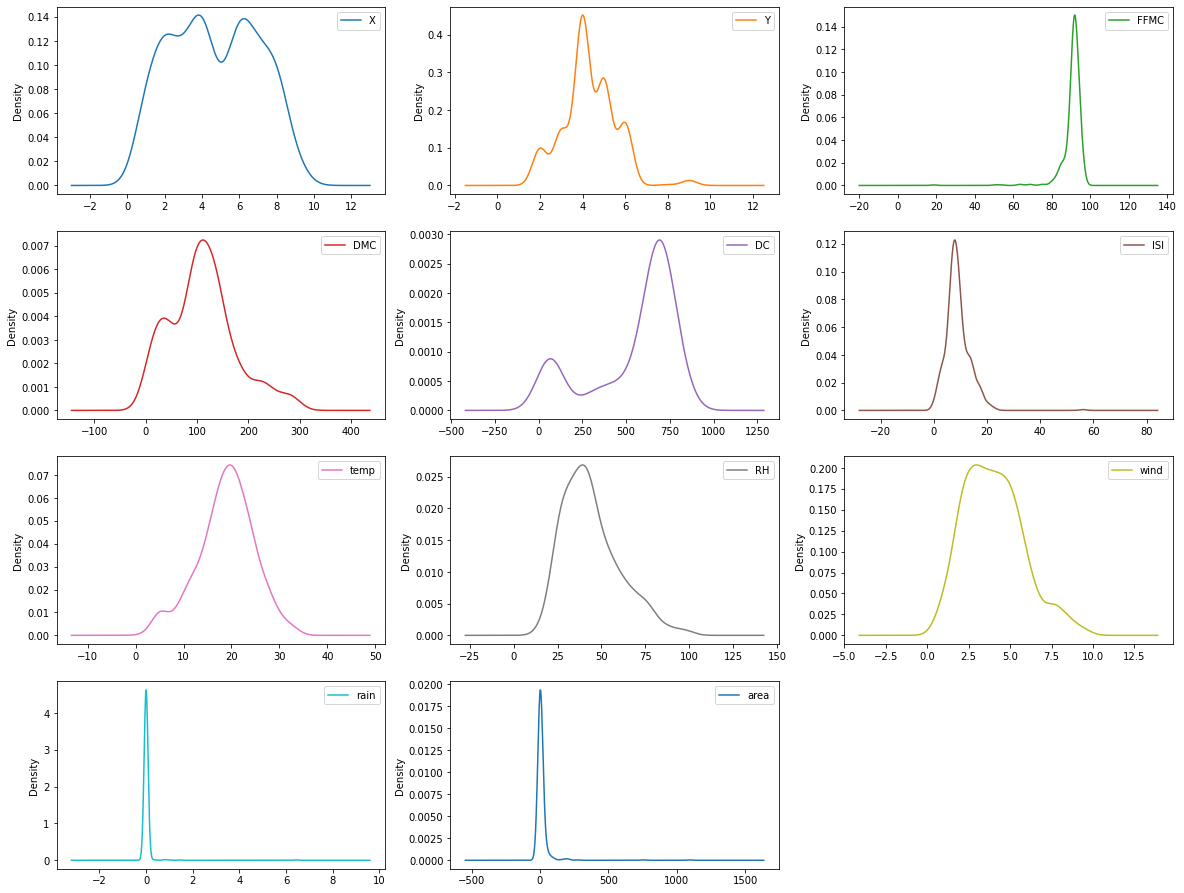

In [9]:
forest.plot(kind='density', subplots=True, layout=(5,3), figsize=(20,20), sharex=False, sharey=False)
plt.show()

# Questions

## Q1 

### Name the variables that explain at least 30 percent of the correlation 

__Viz used__

We found a correlation between each variable and used a heat map to visualize the correlation coefficients.

__Observation__

Overall, `area` doesn't have any strong correlation with other variables as it falls between $-0.064$ to $0.079$.

Considering other variables against each other, we find that `ISI` and `FFMC` have the strongest relationship with the coefficient of $0.78$.

This makes sense since the `FFMC` index measures the moisture content in the surface litter, which usually influences ignition and fire spread whilst `ISI` is the Initial Spread Index.


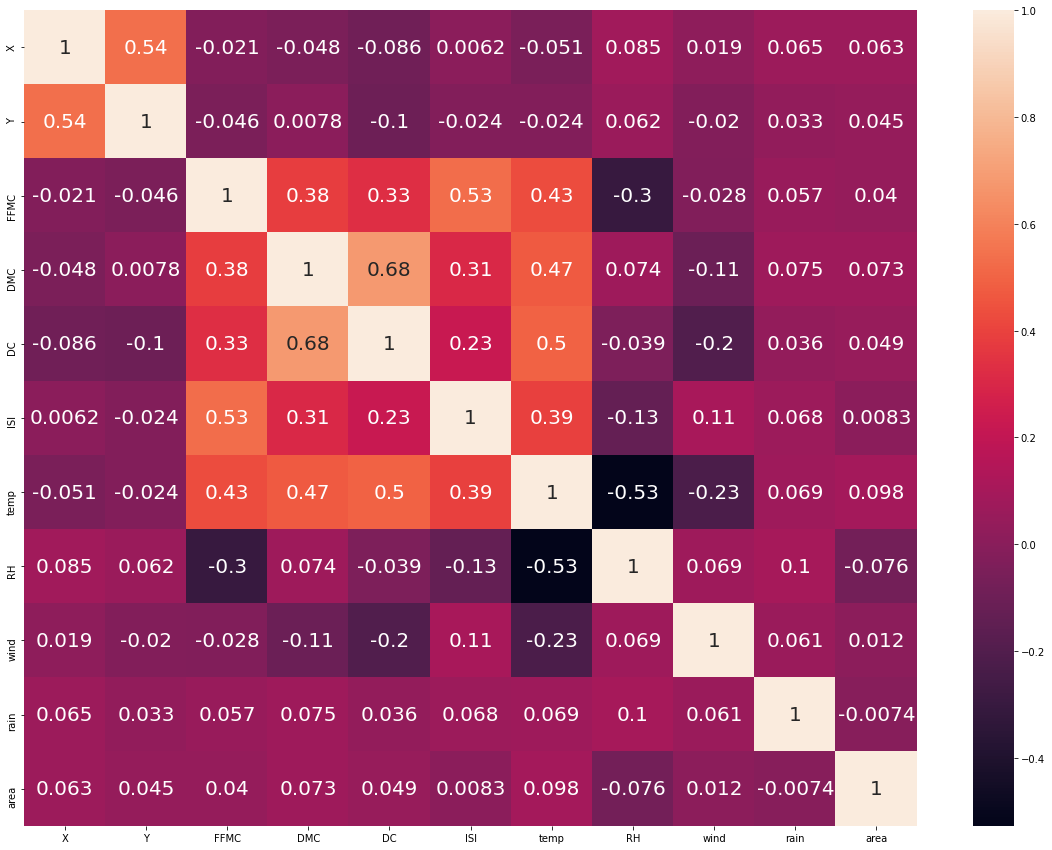

In [10]:
corr = forest.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr,annot=True,annot_kws={"size": 20})
plt.show()

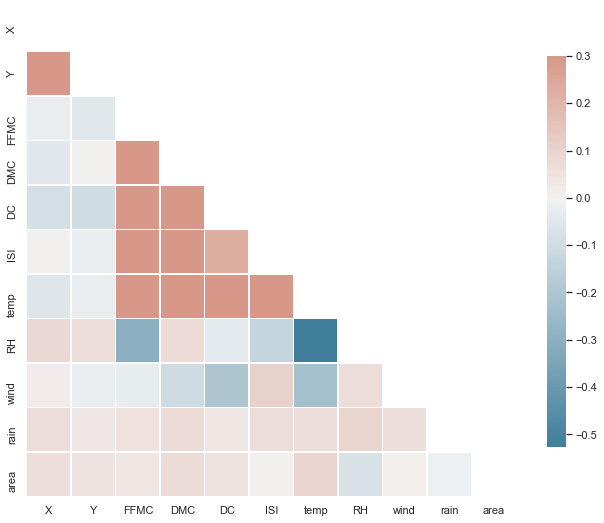

In [11]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = forest.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

plt.show()

__Conclusion:__
- The answer is : X, Y, FFMC, DMC, DC, ISI, temp
- We will let go of the other variables in the correlation matrix

## Q2

### Name the months that have at least 50 forest fires and then for each month, find the corresponding day of the week that contains the most forest fires

In [12]:
# Adjust the dataset
forest2 = forest.iloc[:,0:9]
forest2.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp
0,2,4,jan,sat,82.1,3.7,9.3,2.9,5.3
1,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2
2,3,4,feb,sat,83.9,8.0,30.2,2.6,12.7
3,2,2,feb,fri,86.6,13.2,43.0,5.3,12.3
4,7,4,feb,sun,83.9,8.7,32.1,2.1,8.8


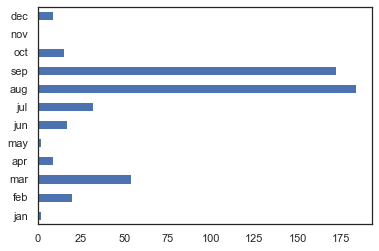

In [13]:
forest2['month'].value_counts().sort_index().plot.barh()
plt.show()

In [14]:
forestsep = forest2.query("month == ['sep']")
forestmar = forest2.query("month == ['mar']")
forestaug = forest2.query("month == ['aug']")

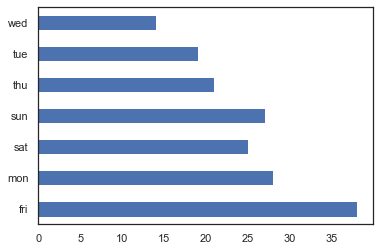

In [15]:
forestsep['day'].value_counts().sort_index().plot.barh()
plt.show()

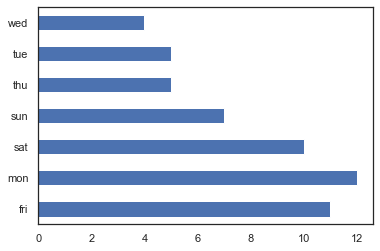

In [16]:
forestmar['day'].value_counts().sort_index().plot.barh()
plt.show()

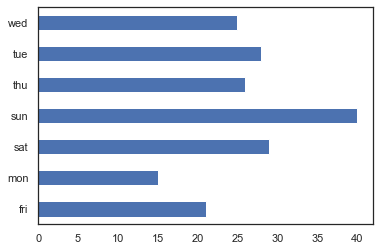

In [17]:
forestaug['day'].value_counts().sort_index().plot.barh()
plt.show()

__Conclusion:__
- Friday on September
- Monday on March
- Sunday on August

## Q3

### What happens when we take the three months in highest forest fires and compare the temperature?

In [18]:
forestmonth = forest2.query("month == ['mar','aug','sep']")
forestmonth.shape

(410, 9)

In [19]:
forestmonth.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp
22,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4
23,4,5,mar,fri,91.2,48.3,97.8,12.5,15.8
24,4,5,mar,fri,91.7,33.3,77.5,9.0,17.2
25,1,3,mar,mon,87.6,52.2,103.8,5.0,8.3
26,5,6,mar,sat,90.6,50.1,100.4,7.8,15.1


<AxesSubplot:xlabel='month', ylabel='temp'>

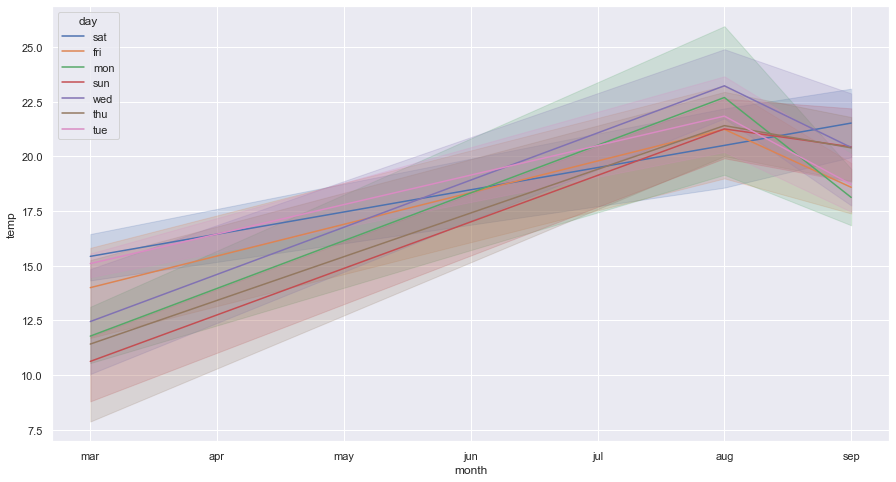

In [20]:
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(x="month",y="temp",hue="day",data=forestmonth)

__Conclusion:__

- This would be pretty obvious given that august and september are summer months
- Interesting fact: on March, it seems that sunday is quite colder in difference compared to saturday

## Q4

### When we take the month and day of most forest fires, what changes in the linear relationship among the column indexes, FFMC to ISI?

In [21]:
forestaug = forest2.query("month == ['aug']")

In [22]:
augsun = forestaug.query("day == ['sun']")
augsun.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp
154,4,5,aug,sun,92.0,203.2,664.5,8.1,10.4
178,2,5,aug,sun,94.9,130.3,587.1,14.1,33.1
179,8,6,aug,sun,94.9,130.3,587.1,14.1,31.0
180,3,4,aug,sun,94.9,130.3,587.1,14.1,23.4
188,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2


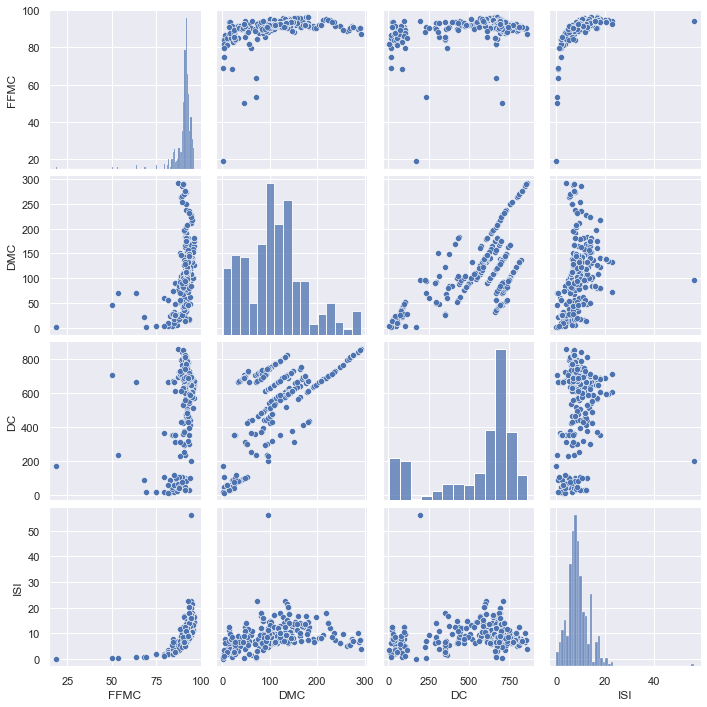

In [23]:
sns.pairplot(forest[["FFMC","DMC","DC","ISI"]])
plt.show()

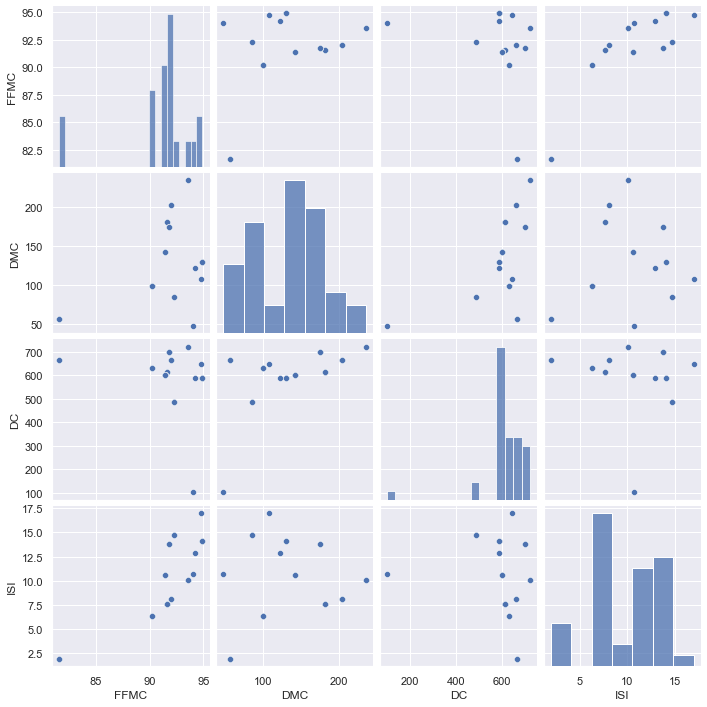

In [24]:
sns.pairplot(augsun[["FFMC","DMC","DC","ISI"]])
plt.show()

__Conclusion:__

- Obviously, we have less data points in the second image
- Generally with more data points, you can see which direction the points are moving
- With the second image, we can see ISI and FFMC are linearly increasing despite the shortage in data points

## Q5

### The highest index column in value is DC. What happens when we compare as we go through all months?

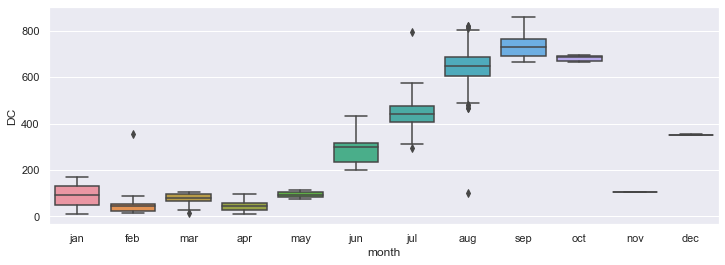

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='DC',data=forest,ax=ax)
plt.show()

__Conclusion:__

- It doesn't matter that the index has the highest values
- You can see how the distribution of data fluctuates across the months
- Some months are just unknown and have nothing to offer


## Q6

### How is area affected based on month and based on day?

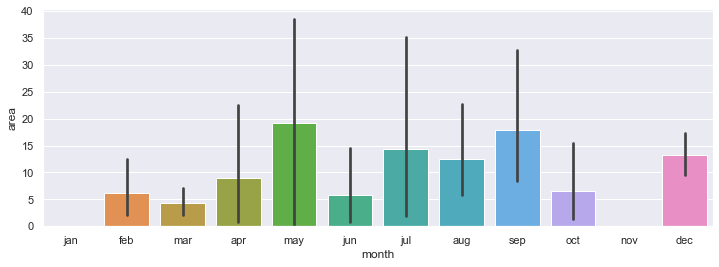

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.barplot(x='month',y='area',data=forest,ax=ax)
plt.show()

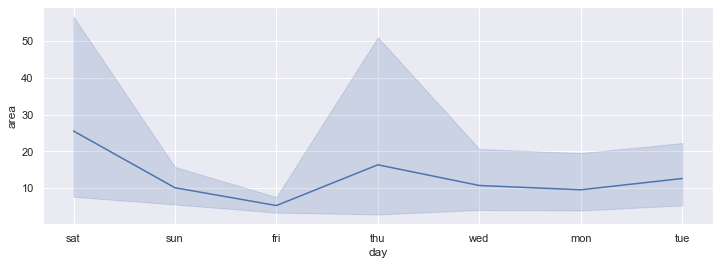

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.lineplot(x='day',y='area',data=forest,ax=ax)
plt.show()

In [28]:
# Bokeh Implementation

source = ColumnDataSource(forest)
areaburnt=forest[forest['area']>0]
areaburnt = dict(zip(areaburnt.month, areaburnt.area))
areaburnt
data = pd.Series(areaburnt).reset_index(name='area').rename(columns={'index':'month'})

data['color'] = Category20c[len(areaburnt)]
data['angle'] = data['area']/data['area'].sum() * 2*pi

p = figure(plot_height=350, title='Area of fire', toolbar_location=None,
           tools="hover", tooltips="@month: @area", plot_width=800)

p.wedge(x=0, y=1, radius=0.4, 
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='month', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

print(data)

  month   area    color     angle
0   feb   5.39  #3182bd  0.129726
1   mar  27.35  #6baed6  0.658259
2   apr  10.93  #9ecae1  0.263063
3   may  38.48  #c6dbef  0.926136
4   jun   3.19  #e6550d  0.076777
5   jul  86.45  #fd8d3c  2.080676
6   aug   5.23  #fdae6b  0.125876
7   sep  12.64  #fdd0a2  0.304219
8   oct  49.37  #31a354  1.188236
9   dec  22.03  #74c476  0.530217


__Conclusion:__

- Aside from a couple months, all area density is below 20 on all months
- Area increases as we approach summer
- There's a huge shift from saturday to sunday probably because activity is quiet

## Q7

### Let's separate month by season and see which season has the most forest fires

In [29]:
summer = forest.query("month == ['jun','jul','aug']")
spring = forest.query("month == ['mar','apr','may']")
fall = forest.query("month == ['sep','oct','nov']")
winter = forest.query("month == ['dec','jan','feb']")

In [30]:
count = []
for i in summer,spring,fall,winter:
    print(i.shape[0])
    count.append(i.shape[0])

233
65
188
31


In [31]:
seasons = ['summer','spring','fall','winter']

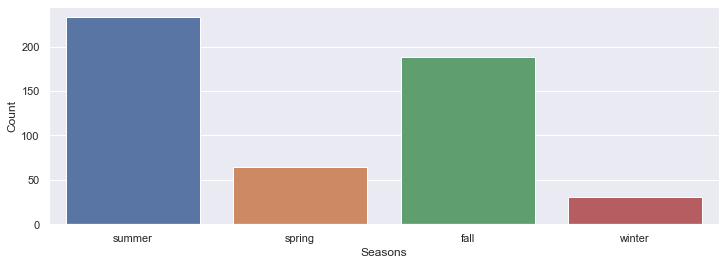

In [32]:
Seasonal = {'Seasons':seasons,'Count':count}
SeasonalCount = pd.DataFrame(Seasonal)
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.barplot(x='Seasons', y='Count', data=SeasonalCount, ax=ax)
plt.show()

__Conclusion:__

- We query seasons based on months, append to different dictionaries and create a dataframe
- From summer to fall, forest fires are high, but the other half of the seasons produces inactivity

## Q8

### Are there more fires in the Summer season compared to other seasons?


__Viz used__

We assigned seasons to the `month` field based on http://www.travelstart.co.za/blog/best-time-to-visit-portugal/
We then plotted the `area` to the `months` with `season` as hue.

__Observation__

Inferring from the second plot, we see that on the average, summer months experience more fires.

In [33]:
month_int_season = {
    'jan' : [1, "winter"],
    'feb' : [2, "winter"],
    'mar' : [3, "spring"],
    'apr' : [4, "spring"],
    'may' : [5, "spring"],
    'jun' : [6, "summer"],
    'jul' : [7, "summer"],
    'aug' : [8, "summer"],
    'sep' : [9, "summer"],
    'oct' : [10, "fall"],
    'nov' : [11, "fall"],
    'dec' : [12, "winter"]
}

forest["month_int_season"] = forest['month'].map(month_int_season) 
forest[['month_int','season']] = pd.DataFrame(forest.month_int_season.to_list())

forest = forest.sort_values(['month_int']).reset_index(drop=True)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


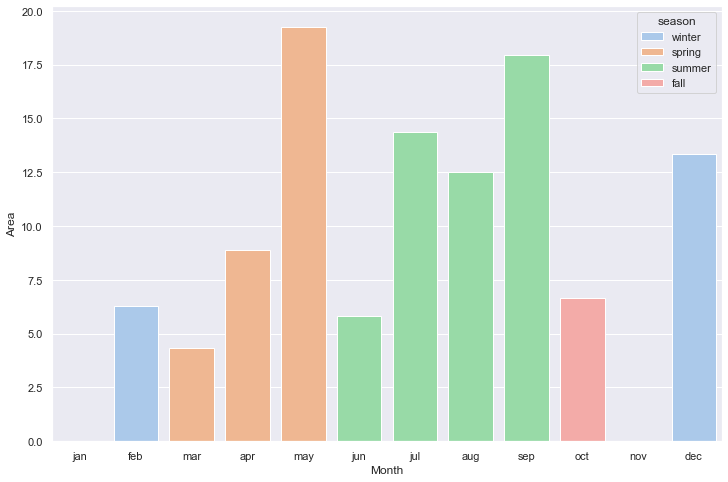

In [34]:
plt.figure(figsize=(12,8))
ax = sns. barplot(x="month", y="area", data=forest, hue="season", ci=None,  dodge=False, palette='pastel')
ax.set(xlabel="Month", ylabel='Area')
plt.show()

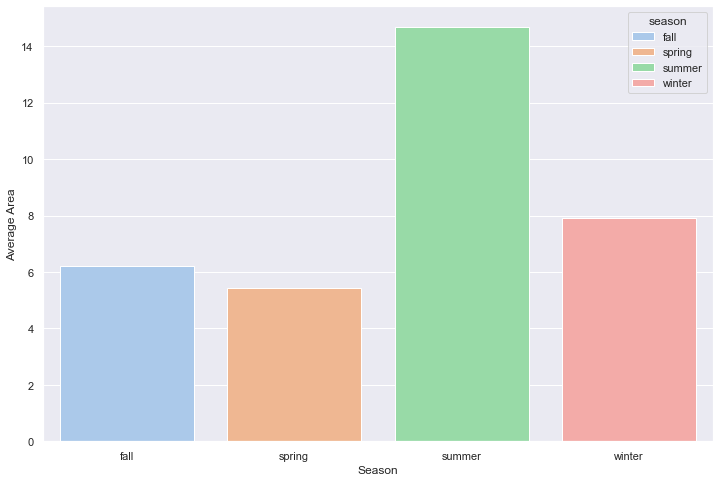

In [35]:
area_by_season = forest.groupby(["season"])[["area"]].mean()
area_by_season = area_by_season.reset_index()
plt.figure(figsize=(12,8))
ax = sns. barplot(x="season", y="area", data=area_by_season, hue="season", ci=None,  dodge=False, palette='pastel')
ax.set(xlabel="Season", ylabel='Average Area')
plt.show()

## Q9
### Does the seasonal forest fire count from above affect the density distribution of our spatial coordinates across each season?

Let's use summer and winter

In [36]:
x1 = summer[['X']]
y1 = summer[['Y']]
x2 = winter[['X']]
y2 = winter[['Y']]

a = summer[['X','Y']]

/Users/ihoney/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ihoney/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ihoney/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

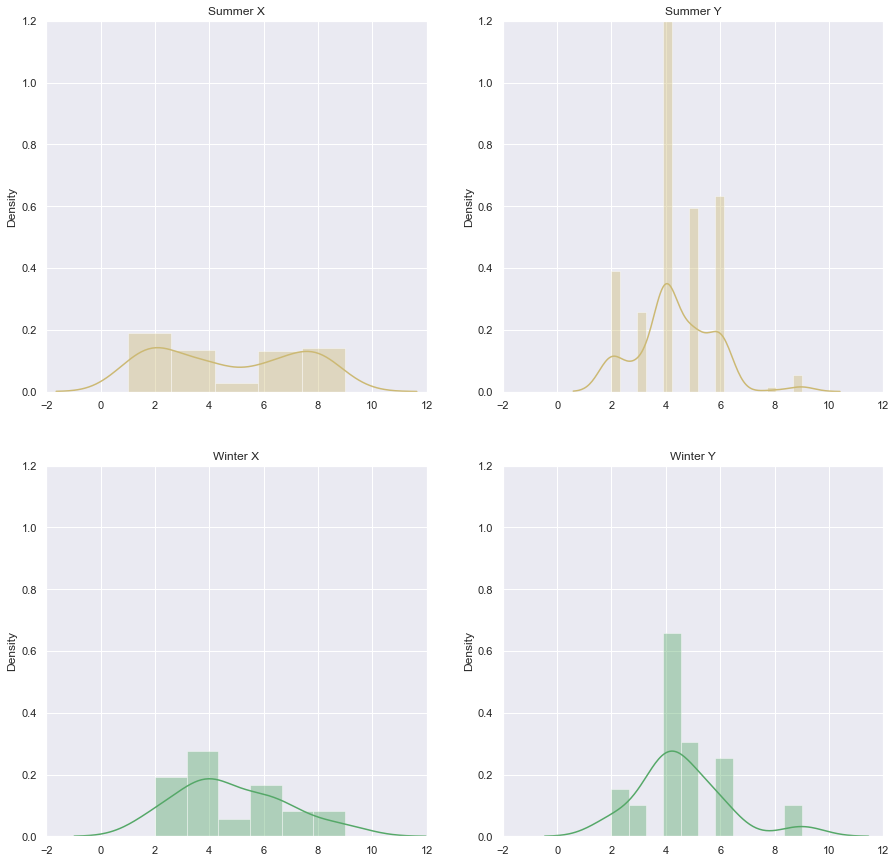

In [37]:
fig_dims = (15, 15)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=fig_dims)

a = sns.distplot(x1, color="y", ax=ax1)
b = sns.distplot(y1, color="y", ax=ax2)
c = sns.distplot(x2, color="g", ax=ax3)
d = sns.distplot(y2, color="g", ax=ax4)
a.set_title("Summer X")
b.set_title("Summer Y")
c.set_title("Winter X")
d.set_title("Winter Y") 

a.set(xlim=(-2,12), ylim=(0, 1.2))
b.set(xlim=(-2,12), ylim=(0, 1.2))
c.set(xlim=(-2,12), ylim=(0, 1.2))
d.set(xlim=(-2,12), ylim=(0, 1.2))

# a.set(xlim=(2,10),ylim=(0,0.18))
# b.set(ylim=(0, 0.18))
# c.set(xlim=(2,10),ylim=(0, 0.18))
# d.set(ylim=(0, 0.18))
plt.grid(True)
plt.show()

__Conclusion:__

- So, we are using the summer and winter season and you can see that the xlim and ylim are the same for the 2 by 2
- The fluctuations in the histogram do not really affect the difference among the density distributions

## Q10

### What is the distribution of `area`?

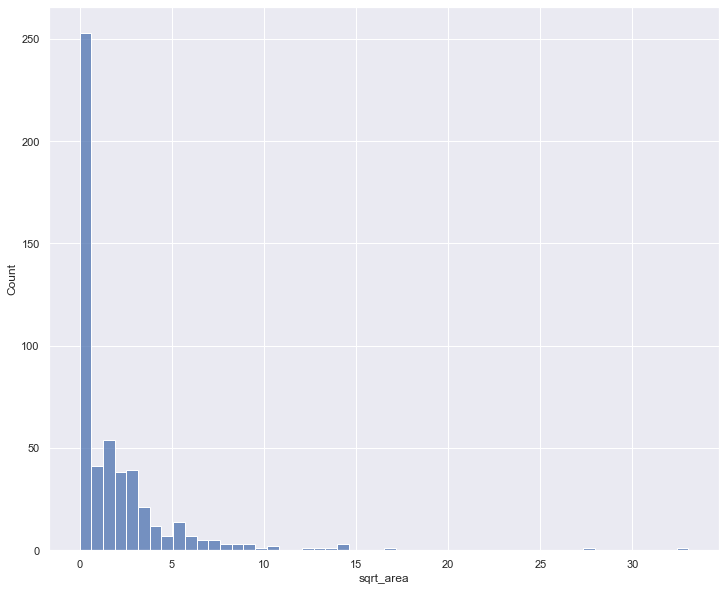

In [38]:
plt.figure(figsize=(12,10))

forest["sqrt_area"] = np.sqrt(forest["area"])
ax = sns.histplot(data=forest, x="sqrt_area")

## Q11

### How's `area` distributed across days?

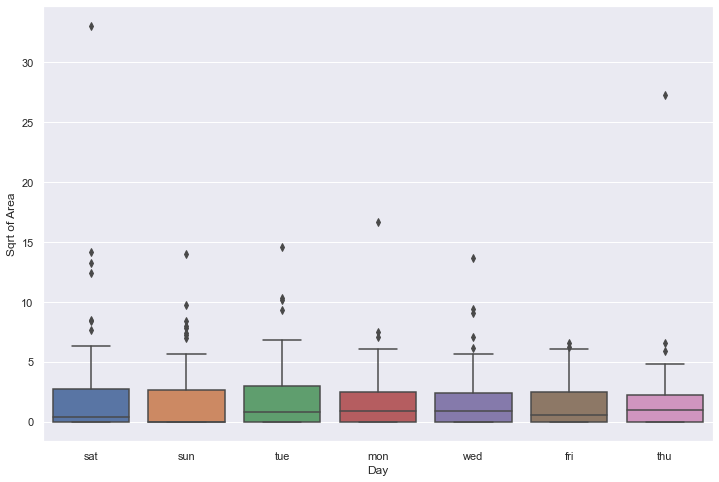

In [39]:
plt.figure(figsize=(12,8))
# sns.histplot(data=forest, x="area")

forest["sqrt_area"] = np.sqrt(forest["area"])
ax = sns.boxplot(x="day", y="sqrt_area", data=forest)
ax.set(xlabel="Day", ylabel='Sqrt of Area')
plt.show()

## Q12 

### How can we visualize the forest fire impact on the map by the area?

In [50]:
url = '/notebooks/images/map.png'

mapper = linear_cmap(field_name='area', 
                     palette=Spectral6, 
                     low=min(forest['area']),
                     high=max(forest['area'])
                    )

size_mapper=LinearInterpolator(
    x=[forest.area.min(),forest.area.max()],
    y=[5,50]
)

p = figure(title='Area of fire',
           x_range=(0,10), 
           y_range=(0,10),
           plot_width=600,
           plot_height=400
          )

p.image_url(url=[url], x=0, y=0, h=10, w=10, anchor="bottom_left")

p.xaxis.axis_label = 'X'
p.yaxis.axis_label = 'Y'

p.scatter('X', 'Y', source=forest, fill_alpha=0.3, size={'field':'area','transform': size_mapper}, color='red')

show(p)


## Q14 

### What is the expected rate of fire spread per month?

In [ ]:
sns.set(style='darkgrid')
plt.subplots(figsize=(20,15))

sns.lineplot(x='month', y='ISI', data = forest, color='red')

plt.title('Initial Spread Index', fontsize = 20)
plt.xlabel('Months', fontsize = 16)
plt.ylabel('ISI', fontsize = 16) 

plt.show()
